In [1]:
# numpy and pandas for data manipulation
import pandas as pd 
import numpy as np

# sklearn 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#gestion du desiquilibre de la classe TARGET
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

#Boosting lightgbm
from lightgbm import LGBMClassifier

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#regEX
import re
from collections import Counter

#serialisation du modele
import pickle

#mesure du temps
import timeit

#  UTILISATION d'une selection dans le jeu complet de données

selection faite dans kernel kaggle : https://www.kaggle.com/hikmetsezen/micro-model-174-features-0-8-auc-on-home-credit

In [2]:
df_features = pd.read_csv('df_features.csv')
df_features

,Unnamed: 0,TARGET,SK_ID_CURR,POS_SK_DPD_DEF_SUM,CC_DRAWING_LIMIT_RATIO_MAX,INSTAL_PAYMENT_RATIO_MEAN,POS_REMAINING_INSTALMENTS,CC_LAST_AMT_BALANCE_MEAN,CC_PAYMENT_DIV_MIN_MIN,CC_LATE_PAYMENT_VAR,...,BURO_CREDIT_TYPE_Mortgage_MEAN,AMT_GOODS_PRICE,APPROVED_CNT_PAYMENT_MEAN,FLAG_DOCUMENT_7,FLAG_DOCUMENT_18,NONLIVINGAPARTMENTS_MEDI,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ORGANIZATION_TYPE_Construction,INSTAL_AMT_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MEAN
0,0,1,100002,0.0,NaN,1.00000,6.0,NaN,NaN,NaN,...,0.0,351000.0,24.00,0,0,0.0000,40.5000,False,9251.775,49156.20
1,1,0,100003,0.0,NaN,1.00000,1.0,NaN,NaN,NaN,...,0.0,1129500.0,10.00,0,0,0.0039,0.0000,False,6662.970,0.00
2,2,0,100004,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,0.0,135000.0,4.00,0,0,NaN,NaN,False,5357.250,0.00
3,3,0,100006,0.0,NaN,1.00000,3.0,0.0,NaN,0.0,...,NaN,297000.0,18.00,0,0,NaN,NaN,False,2482.920,NaN
4,4,0,100007,0.0,NaN,1.00000,14.0,NaN,NaN,NaN,...,0.0,513000.0,20.67,0,0,NaN,NaN,False,0.180,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,307501,0,456251,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,NaN,225000.0,8.00,0,0,0.0757,NaN,False,6605.910,NaN
307502,307502,0,456252,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,NaN,225000.0,6.00,0,0,0.0000,NaN,False,10046.880,NaN
307503,307503,0,456253,5.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,0.0,585000.0,5.00,0,0,0.0000,NaN,False,27.270,448958.25
307504,307504,1,456254,0.0,NaN,1.00000,12.0,NaN,NaN,NaN,...,0.0,319500.0,15.00,0,0,NaN,NaN,False,2296.440,0.00


In [3]:
df_features.drop(columns='Unnamed: 0', inplace=True)
df_features = df_features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X_features = df_features.drop(columns='TARGET').copy()
y_features= df_features['TARGET'].copy()

## imputation valeurs simples

In [4]:
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
col_num = list(df_features.select_dtypes('float64').columns)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
df_features[col_num] = imp_mean.fit_transform(df_features[col_num])

In [5]:
col_num = list(df_features.select_dtypes('int64').columns)
imp_meanN = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
df_features[col_num] = imp_meanN.fit_transform(df_features[col_num])

In [6]:
X_feats_impute = df_features.drop(columns='TARGET').copy()
y_feats_impute = df_features['TARGET'].copy()

### separation train/test set

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_feats_impute, y_feats_impute, test_size=0.2, stratify=y_feats_impute, random_state=1944)
X_feats_train, X_feats_val, y_feats_train, y_feats_val = train_test_split(X_features, y_features, test_size=0.2, stratify=y_features, random_state=1944)

In [8]:
print('y_train', Counter(y_train))
print('y_val', Counter(y_val))

y_train Counter({0.0: 226145, 1.0: 19859})
y_val Counter({0.0: 56537, 1.0: 4965})


# definition metrique et fonction evaluation

### Score métier = 10*FN + FP

In [17]:
import os
import mlflow
import mlflow.sklearn
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, fbeta_score, roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.dummy import DummyClassifier

# Définir l'URI de suivi MLflow
mlflow.set_tracking_uri("file:///C:/Users/saidi/Projet_7/mlruns")

def set_experiment_name(model_name):
    """
    Configure l'expérience MLflow en fonction du modèle.
    """
    experiment_name = f"Projet 7 - {model_name}"
    mlflow.set_experiment(experiment_name)

def custom_metric(y, y_pred):
    TP = np.sum((y == 1) & (y_pred == 1))
    FP = np.sum((y == 0) & (y_pred == 1))
    TN = np.sum((y == 0) & (y_pred == 0))
    FN = np.sum((y == 1) & (y_pred == 0))
    PPV = TP / (TP + FP) if (TP + FP) > 0 else 0
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FMI = np.sqrt(PPV * TPR) if PPV and TPR else 0
    return FMI

def custom_metric_f2(y, y_pred):
    return fbeta_score(y, y_pred, beta=2)

def custom_cost(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = fp + 10 * fn
    max_cost = 10 * len(y_true)
    cost_normalized = cost / max_cost
    return cost_normalized

def safe_metric(metric_func, y_true, y_pred, *args, **kwargs):
    try:
        return metric_func(y_true, y_pred, *args, **kwargs)
    except ValueError:
        return float('nan')

def model_eval_score(model, Xval, yval, strategy):
    with mlflow.start_run:
        yval_pred = model.predict(Xval)
        yval_proba = model.predict_proba(Xval)[:, 1]
        
        conf_mat = confusion_matrix(yval, yval_pred)
        accuracy = accuracy_score(yval, yval_pred)
        precision = safe_metric(precision_score, yval, yval_pred)
        recall = safe_metric(recall_score, yval, yval_pred)
        f1 = safe_metric(f1_score, yval, yval_pred)
        f2 = safe_metric(fbeta_score, yval, yval_pred, beta=2)
        rocauc = safe_metric(roc_auc_score, yval, yval_pred)
        custom_metric_value = safe_metric(custom_metric, yval, yval_pred)
        custom_cost_value = custom_cost(yval, yval_proba)
        
        # Log metrics to MLflow
        mlflow.log_param("Strategy", strategy)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1", f1)
        mlflow.log_metric("F2", f2)
        mlflow.log_metric("ROCAUC", rocauc)
        mlflow.log_metric("Custom Metric FMI", custom_metric_value)
        mlflow.log_metric("Custom Cost", custom_cost_value)
        
        # Print metrics with updated formatting
        print(conf_mat)
        print(f'Accuracy score    : {accuracy:.3f}')
        print(f'Precision score   : {precision:.3f}')
        print(f'Recall score      : {recall:.3f}')
        print(f'F1 score          : {f1:.3f}')
        print(f'F2 score          : {f2:.3f}')
        print(f'ROCAUC score      : {rocauc:.3f}')
        print(f'Custom metric FMI : {custom_metric_value:.3f}')
        print(f'Custom cost       : {custom_cost_value:.3f}')
        print()

def model_eval(model, Xval, yval, strategy):
    start_time_fit = time.time()
    model.fit(Xval, yval)
    elapsed_time_fit = time.time() - start_time_fit

    start_time_predict = time.time()
    model_eval_score(model, Xval, yval, strategy)
    elapsed_time_predict = time.time() - start_time_predict

    yval_proba = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, yval_proba)
    roc_auc = auc(fpr, tpr)

    # Save ROC curve plot
    plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('roc_curve.png')  # Save the plot
    plt.close()  # Close the plot to free memory

    # Log ROC curve plot to MLFlow
    mlflow.log_artifact('roc_curve.png')

    # Log times to MLFlow
    mlflow.log_metric("Fit Time", elapsed_time_fit)
    mlflow.log_metric("Prediction Time", elapsed_time_predict)

    # Log the model to MLFlow
    mlflow.sklearn.log_model(model, "model")

    # Optionally display the ROC curve
    plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [86]:
import warnings
warnings.filterwarnings('ignore', message='Distutils was imported before Setuptools')
warnings.filterwarnings('ignore', message='Setuptools is replacing distutils')

import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import time
import lightgbm as lgb

# Charger les données
df_classification_imputed = pd.read_csv('df_features.csv')  # Remplacez par le chemin de vos données

nb_0 = (df_classification_imputed['TARGET'] == 0).sum()
nb_1 = (df_classification_imputed['TARGET'] == 1).sum()

X_train = df_classification_imputed.drop(columns=["TARGET", "SK_ID_CURR"])
Y_train = df_classification_imputed["TARGET"]

# Convertir les colonnes en type float pour éviter les problèmes avec les NaN
X_train = X_train.astype(float)

# Remplacer les valeurs infinies par NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Imputer les valeurs manquantes par la moyenne des colonnes
X_train.fillna(X_train.mean(), inplace=True)

# StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Class weights
class_weights = {0: 1, 1: nb_0 / nb_1}

# Fonction pour calculer le coût personnalisé
def custom_cost(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = fp + 10 * fn
    max_cost = 10 * len(y_true)
    cost_normalized = cost / max_cost
    return cost_normalized

# Fonction pour entraîner et évaluer un pipeline
def train_and_evaluate_model(pipeline: Pipeline, model_name: str, strategy_name: str, params: dict, X: np.ndarray, Y: pd.Series, experiment_name: str):
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=f"{model_name} - {strategy_name}"):
        start_time_fit = time.time()
        
        cv = StratifiedKFold(n_splits=5)
        # Fit le pipeline sur l'ensemble d'entraînement
        pipeline.fit(X, Y)
        
        # Prédictions de probabilité avec le pipeline
        y_prob = cross_val_predict(pipeline, X, Y, cv=cv, method="predict_proba")[:, 1]
        elapsed_time_fit = time.time() - start_time_fit

        start_time_predict = time.time()
        y_pred = y_prob > params.get('threshold', 0.5)
        elapsed_time_predict = time.time() - start_time_predict

        auc = roc_auc_score(Y, y_prob)
        acc = accuracy_score(Y, y_pred)
        cost_normalized = custom_cost(Y, y_prob, params.get('threshold', 0.5))

        # Log parameters and metrics
        mlflow.log_params(params)
        mlflow.log_param("Model", model_name)
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Business Score", cost_normalized)
        mlflow.log_metric("Fit Time", elapsed_time_fit)
        mlflow.log_metric("Prediction Time", elapsed_time_predict)

        # Log the pipeline model
        mlflow.sklearn.log_model(pipeline, "model")

        # ROC Curve
        fpr, tpr, thresholds = roc_curve(Y, y_prob)

        # Save ROC curve plot
        plt.figure()
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label=f'AUC = {auc:.2f}')
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.text(0.6, 0.2, f'Model: {model_name}\nAUC: {auc:.2f}\nAccuracy: {acc:.2f}\nBusiness Score: {cost_normalized:.2f}', bbox=dict(facecolor='white', alpha=0.5))
        plt.savefig(f'roc_curve_{model_name}_{strategy_name}.png')  # Save the plot
        plt.close()  # Close the plot to free memory

        # Log ROC curve plot to MLFlow
        mlflow.log_artifact(f'roc_curve_{model_name}_{strategy_name}.png')

        return {
            "Model": model_name,
            "Strategy": strategy_name,
            "AUC": auc,
            "Accuracy": acc,
            "Business Score": cost_normalized,
            "Pipeline": pipeline  # Return the pipeline
        }

In [36]:
# Dummy Classifier
experiment_name = "Dummy_Experiment"
pipeline_dummy = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DummyClassifier(strategy="most_frequent"))
])
results_dummy = train_and_evaluate_model(pipeline_dummy, "Dummy - None", {'threshold': 0.5}, X_train, Y_train, experiment_name)


2024/08/05 22:19:20 INFO mlflow.tracking.fluent: Experiment with name 'Dummy_Experiment' does not exist. Creating a new experiment.


## gestion desequilibre
https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

### gestion desequilibre
#### essai sous echantillonage

In [38]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [40]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Définir le modèle et le pipeline sans équilibrage
pipeline_rf = ImbPipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight=class_weights))
])
results_rf_none = train_and_evaluate_model(pipeline_rf, "RandomForest - None", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [41]:
pipeline_rf_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', SMOTE()),
    ('classifier', RandomForestClassifier(class_weight=class_weights))
])
results_rf_smote = train_and_evaluate_model(pipeline_rf_smote, "RandomForest - SMOTE", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [42]:
pipeline_rf_over = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomOverSampler()),
    ('classifier', RandomForestClassifier(class_weight=class_weights))
])
results_rf_over = train_and_evaluate_model(pipeline_rf_over, "RandomForest - OverSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [43]:
pipeline_rf_under = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomUnderSampler()),
    ('classifier', RandomForestClassifier(class_weight=class_weights))
])
results_rf_under = train_and_evaluate_model(pipeline_rf_under, "RandomForest - UnderSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [45]:
# LGBMClassifier
experiment_name = "LGBMClassifier_Experiment"

# Without balancing
pipeline_lgbm = ImbPipeline([
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(class_weight=class_weights))
])
results_lgbm_none = train_and_evaluate_model(pipeline_lgbm, "LGBMClassifier - None", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [46]:
# With SMOTE
pipeline_lgbm_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', SMOTE()),
    ('classifier', LGBMClassifier(class_weight=class_weights))
])
results_lgbm_smote = train_and_evaluate_model(pipeline_lgbm_smote, "LGBMClassifier - SMOTE", {'threshold': 0.5}, X_train, Y_train, experiment_name)



In [47]:
# With Random Over Sampling
pipeline_lgbm_over = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomOverSampler()),
    ('classifier', LGBMClassifier(class_weight=class_weights))
])
results_lgbm_over = train_and_evaluate_model(pipeline_lgbm_over, "LGBMClassifier - OverSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [48]:
# With Random Under Sampling
pipeline_lgbm_under = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomUnderSampler()),
    ('classifier', LGBMClassifier(class_weight=class_weights))
])
results_lgbm_under = train_and_evaluate_model(pipeline_lgbm_under, "LGBMClassifier - UnderSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [49]:
# Logistic Regression
experiment_name = "LogisticRegression_Experiment"

# Sans équilibrage
pipeline_lr_none = ImbPipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight=class_weights))
])
results_lr_none = train_and_evaluate_model(pipeline_lr_none, "LogisticRegression - None", {'threshold': 0.5}, X_train, Y_train, experiment_name)



2024/08/06 10:47:54 INFO mlflow.tracking.fluent: Experiment with name 'LogisticRegression_Experiment' does not exist. Creating a new experiment.


In [51]:
# Avec SMOTE
pipeline_lr_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', SMOTE()),
    ('classifier', LogisticRegression(class_weight=class_weights))
])
results_lr_smote = train_and_evaluate_model(pipeline_lr_smote, "LogisticRegression - SMOTE", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [52]:
# Avec Random Over Sampling
pipeline_lr_over = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomOverSampler()),
    ('classifier', LogisticRegression(class_weight=class_weights))
])
results_lr_over = train_and_evaluate_model(pipeline_lr_over, "LogisticRegression - OverSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)



In [53]:
# Avec Random Under Sampling
pipeline_lr_under = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomUnderSampler()),
    ('classifier', LogisticRegression(class_weight=class_weights))
])
results_lr_under = train_and_evaluate_model(pipeline_lr_under, "LogisticRegression - UnderSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)

In [54]:
# Decision Tree Classifier
experiment_name = "DecisionTreeClassifier_Experiment"

# Sans équilibrage
pipeline_dt_none = ImbPipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(class_weight=class_weights))
])
results_dt_none = train_and_evaluate_model(pipeline_dt_none, "DecisionTreeClassifier - None", {'threshold': 0.5}, X_train, Y_train, experiment_name)

2024/08/06 11:11:45 INFO mlflow.tracking.fluent: Experiment with name 'DecisionTreeClassifier_Experiment' does not exist. Creating a new experiment.


In [55]:
# Avec SMOTE
pipeline_dt_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', SMOTE()),
    ('classifier', DecisionTreeClassifier(class_weight=class_weights))
])
results_dt_smote = train_and_evaluate_model(pipeline_dt_smote, "DecisionTreeClassifier - SMOTE", {'threshold': 0.5}, X_train, Y_train, experiment_name)



In [56]:
# Avec Random Over Sampling
pipeline_dt_over = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomOverSampler()),
    ('classifier', DecisionTreeClassifier(class_weight=class_weights))
])
results_dt_over = train_and_evaluate_model(pipeline_dt_over, "DecisionTreeClassifier - OverSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)



In [57]:
# Avec Random Under Sampling
pipeline_dt_under = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomUnderSampler()),
    ('classifier', DecisionTreeClassifier(class_weight=class_weights))
])
results_dt_under = train_and_evaluate_model(pipeline_dt_under, "DecisionTreeClassifier - UnderSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [58]:
# Afficher les résultats pour chaque modèle
print("Results for Dummy Classifier:")
print(results_dummy)
print("\n")

print("Results for RandomForest Classifier:")
print(results_rf_none)
print(results_rf_smote)
print(results_rf_over)
print(results_rf_under)
print("\n")

print("Results for LGBMClassifier:")
print(results_lgbm_none)
print(results_lgbm_smote)
print(results_lgbm_over)
print(results_lgbm_under)
print("\n")

print("Results for Logistic Regression:")
print(results_lr_none)
print(results_lr_smote)
print(results_lr_over)
print(results_lr_under)
print("\n")

print("Results for Decision Tree Classifier:")
print(results_dt_none)
print(results_dt_smote)
print(results_dt_over)
print(results_dt_under)
print("\n")


Results for Dummy Classifier:
{'Model': 'Dummy - None', 'AUC': 0.5, 'Accuracy': 0.9192731198740838, 'Business Score': 0.08072688012591624, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', DummyClassifier(strategy='most_frequent'))])}


Results for RandomForest Classifier:
{'Model': 'RandomForest - None', 'AUC': 0.7358977767580526, 'Accuracy': 0.9192861277503528, 'Business Score': 0.08056233049111237, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1,
                                                      1: 11.387447631324525}))])}
{'Model': 'RandomForest - SMOTE', 'AUC': 0.6955372276134193, 'Accuracy': 0.911598472875326, 'Business Score': 0.07833408128621881, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()), ('balancer', SMOTE()),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1,
                      

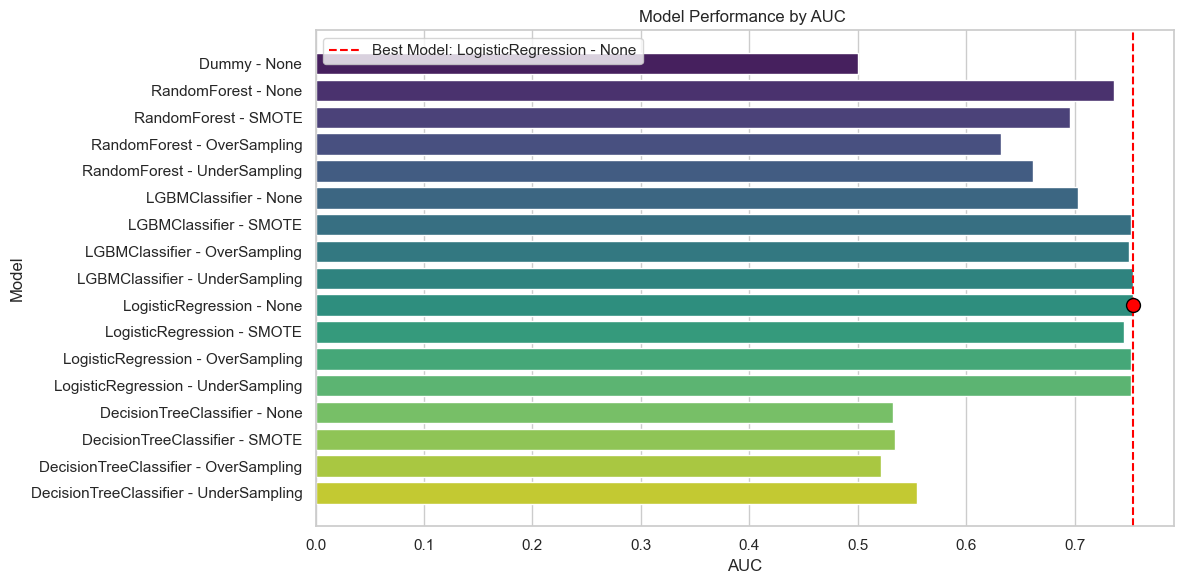

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model results
data = {
    'Model': [
        'Dummy - None', 'RandomForest - None', 'RandomForest - SMOTE', 'RandomForest - OverSampling', 'RandomForest - UnderSampling',
        'LGBMClassifier - None', 'LGBMClassifier - SMOTE', 'LGBMClassifier - OverSampling', 'LGBMClassifier - UnderSampling',
        'LogisticRegression - None', 'LogisticRegression - SMOTE', 'LogisticRegression - OverSampling', 'LogisticRegression - UnderSampling',
        'DecisionTreeClassifier - None', 'DecisionTreeClassifier - SMOTE', 'DecisionTreeClassifier - OverSampling', 'DecisionTreeClassifier - UnderSampling'
    ],
    'AUC': [
        0.5, 0.7358977767580526, 0.6955372276134193, 0.6323890501353157, 0.6620171154459377,
        0.703070987793061, 0.751823232682771, 0.7498417140037283, 0.7535309931419462,
        0.7539691570925182, 0.7456759122758687, 0.7523356765060771, 0.7518663442908828,
        0.5326406378985901, 0.5339288766254082, 0.5219091461843423, 0.5544476832453639
    ],
    'Accuracy': [
        0.9192731198740838, 0.9192861277503528, 0.911598472875326, 0.9179853401234448, 0.794459295103185,
        0.7649476758177076, 0.6290999200015609, 0.26787444797825083, 0.23041501629236502,
        0.6892873634985984, 0.1518799633177889, 0.09827775718197368, 0.0981769461408883,
        0.8609880782813993, 0.8383933972020058, 0.8821649008474631, 0.6791152042561771
    ],
    'Business Score': [
        0.08072688012591624, 0.08056233049111237, 0.07833408128621881, 0.07934186650016585, 0.06581660195248223,
        0.05589289314680039, 0.055057462293418666, 0.07637639590772212, 0.07912723654172601,
        0.053668871501694276, 0.0856314998731732, 0.09032734320631142, 0.09034913139906213,
        0.07630582817896236, 0.0764024116602603, 0.07773246700877381, 0.07526129571455516
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Determine the best model based on AUC
best_model = df.loc[df['AUC'].idxmax()]
best_model_name = best_model['Model']

# Set the style
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(12, 6))

# Plot all models
sns.barplot(x='AUC', y='Model', data=df, palette="viridis", ci=None, dodge=False)

# Highlight the best model
plt.axvline(x=best_model['AUC'], color='red', linestyle='--', label=f'Best Model: {best_model_name}')
plt.scatter(best_model['AUC'], best_model_name, color='red', s=100, edgecolor='black', zorder=5)

# Add titles and labels
plt.title('Model Performance by AUC ')
plt.xlabel('AUC')
plt.ylabel('Model')
plt.legend()

plt.tight_layout()
plt.show()


### Enregistrement des Résultats d'Importance Globale

In [102]:
from sklearn.model_selection import train_test_split
from collections import Counter

df_total, _ = train_test_split(df_features, train_size=1500, stratify=df_features.TARGET, random_state=1944)

print('df_features', Counter(df_features.TARGET))
print('df_total', Counter(df_total.TARGET))

df_features Counter({0.0: 282682, 1.0: 24824})
df_total Counter({0.0: 1379, 1.0: 121})


In [128]:
df_total = pd.read_csv('df_total.csv', index_col=0)
df_features = pd.read_csv('df_features.csv')

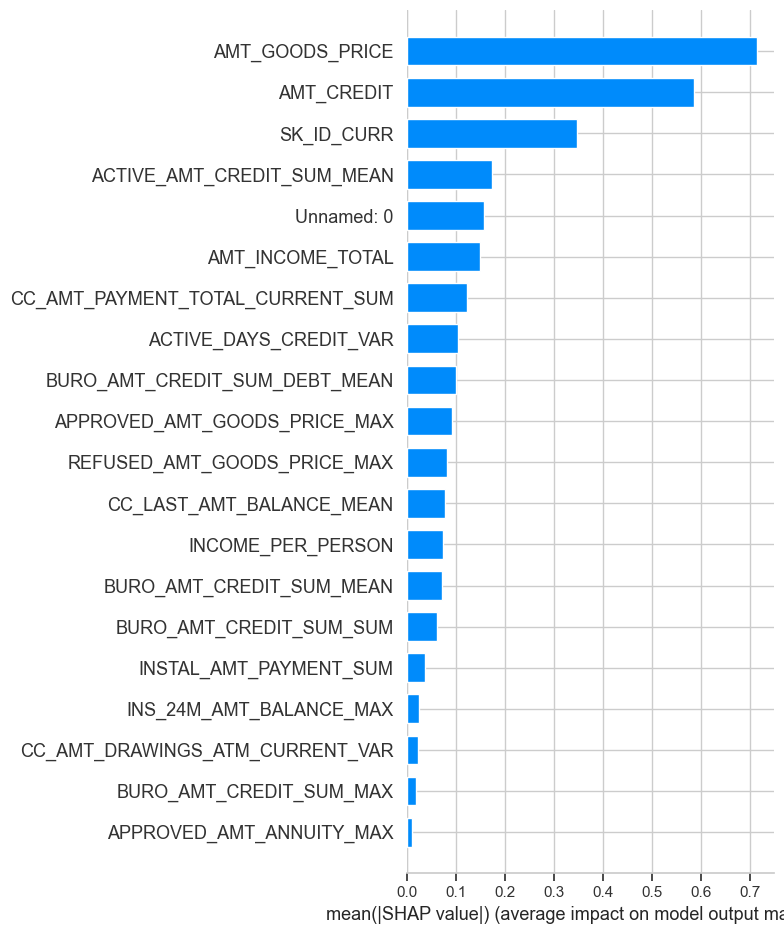

In [129]:
import shap
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Charger les données
# Assurez-vous que df_features est déjà chargé dans votre environnement
# df_features = pd.read_csv('path_to_your_data.csv')

# Exemple d'entraînement du modèle
df_total, df_test = train_test_split(df_features, train_size=0.7, stratify=df_features.TARGET, random_state=1944)
df_total_target = df_total.TARGET
df_total.drop(columns='TARGET', inplace=True)
df_test_target = df_test.TARGET
df_test.drop(columns='TARGET', inplace=True)

# Remplacer les valeurs infinies par NaN
df_total.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Imputer les valeurs manquantes avec la moyenne
imputer = SimpleImputer(strategy='mean')
df_total = pd.DataFrame(imputer.fit_transform(df_total), columns=df_total.columns)
df_test = pd.DataFrame(imputer.transform(df_test), columns=df_test.columns)

# Entraîner le modèle
model = LogisticRegression(max_iter=1000)
model.fit(df_total, df_total_target)

# Utiliser LinearExplainer pour expliquer le modèle de régression logistique
explainer_shap = shap.LinearExplainer(model, df_total)

# Calculer les valeurs de Shapley pour les données de test
shap_values_LR = explainer_shap.shap_values(df_test)

# Visualiser les valeurs de Shapley - Importance globale des features
shap.summary_plot(shap_values_LR, df_test, plot_type="bar")

# Visualiser les valeurs de Shapley - Importance locale pour un client spécifique
shap.initjs()
# Prenons le premier client dans df_test comme exemple
client_index = 0
shap.force_plot(explainer_shap.expected_value, shap_values_LR[client_index], df_test.iloc[client_index])


In [ ]:
import shap
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Exemple d'entraînement du modèle
df_total, df_test = train_test_split(df_features, train_size=1500, stratify=df_features.TARGET, random_state=1944)
df_total_target = df_total.TARGET
df_total.drop(columns='TARGET', inplace=True)
df_features.drop(columns='TARGET', inplace=True)

# Remplacer les valeurs infinies par NaN
df_total.replace([np.inf, -np.inf], np.nan, inplace=True)
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Imputer les valeurs manquantes avec la moyenne
imputer = SimpleImputer(strategy='mean')
df_total = pd.DataFrame(imputer.fit_transform(df_total), columns=df_total.columns)
df_features = pd.DataFrame(imputer.transform(df_features), columns=df_features.columns)

# Entraîner le modèle
model = LogisticRegression()
model.fit(df_total, df_total_target)

# Utiliser LinearExplainer pour expliquer le modèle de régression logistique
explainer_shap = shap.LinearExplainer(model, df_total)

# Calculer les valeurs de Shapley
shap_values_LR = explainer_shap.shap_values(df_features)

# Visualiser les valeurs de Shapley
shap.summary_plot(shap_values_LR, df_features, plot_type="bar")



In [123]:
f = plt.figure()
shap.summary_plot(shap_values, df_features)
f.savefig("summary_plot_lR", bbox_inches='tight', dpi=150)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

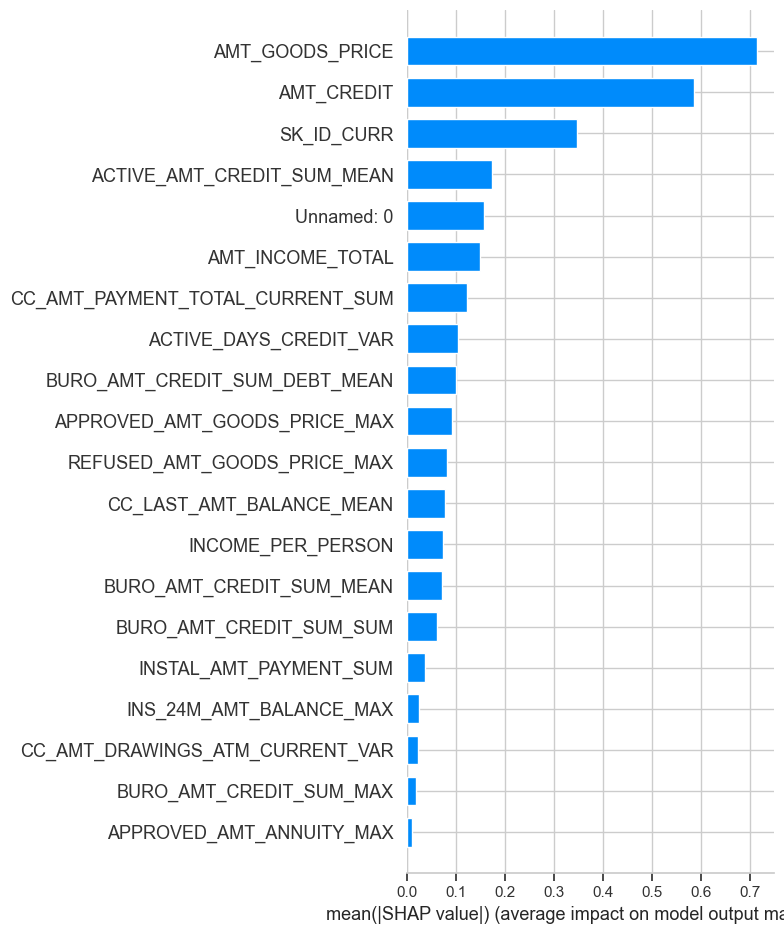

In [122]:
import shap
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

df_total = pd.read_csv('df_total.csv', index_col=0)
df_features = pd.read_csv('df_features.csv')

# Préparation des données
df_total, df_test = train_test_split(df_features, test_size=0.3, stratify=df_features.TARGET, random_state=1944)
df_total_target = df_total.TARGET
df_total.drop(columns='TARGET', inplace=True)
df_test_target = df_test.TARGET
df_test.drop(columns='TARGET', inplace=True)

# Remplacer les valeurs infinies par NaN et imputer les valeurs manquantes
df_total.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='mean')
df_total = pd.DataFrame(imputer.fit_transform(df_total), columns=df_total.columns)
df_test = pd.DataFrame(imputer.transform(df_test), columns=df_test.columns)

# Entraînement du modèle
model = LogisticRegression(max_iter=1000)
model.fit(df_total, df_total_target)

# Utilisation de SHAP pour expliquer le modèle
explainer_shap = shap.LinearExplainer(model, df_total)
shap_values = explainer_shap.shap_values(df_test)

# Visualisation des valeurs de Shapley - Importance globale des features
shap.summary_plot(shap_values, df_test, plot_type="bar")

# Visualisation des valeurs de Shapley - Importance locale pour un client spécifique
shap.initjs()
# Prenons le premier client dans df_test comme exemple
client_index = 0
shap.force_plot(explainer_shap.expected_value, shap_values[client_index,:], df_test.iloc[client_index,:])
